# Boston Housing Price (Scalar) Regression using Densely Connected Neural Network

In [4]:
# Imports required packages

from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Loads preprocessed data

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [6]:
# Checks for data shape

print("Train data shape:", x_train.shape,
      "\nTest data shape:", x_test.shape)

Train data shape: (404, 13) 
Test data shape: (102, 13)


In [7]:
# Prepares training and validation data

# normalizes data
x_train_mean = x_train.mean(axis=0)
x_train_std = x_train.std(axis=0)
x_train -= x_train_mean
x_train /= x_train_std

x_test -= x_train_mean
x_test /= x_train_std

# Seperates validation data
val_samples_count = 104

x_val = x_train[:val_samples_count]
x_train = x_train[val_samples_count:]

y_val = y_train[:val_samples_count]
y_train = y_train[val_samples_count:]

In [8]:
# Checks for data shape after data split between training and validation

print("Train data shape:", x_train.shape,
      "\nTest data shape:", x_val.shape)

Train data shape: (300, 13) 
Test data shape: (104, 13)


In [9]:
# Function that creates and returms the model
    
def create_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

In [43]:
# Trains model with Stand-out Validation

epoch_count = 100

model = create_model()

history = model.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    batch_size=1, 
                    epochs=epoch_count, 
                    verbose=0)

In [44]:
# Checks for keys in history dictionary

history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [45]:
# Checks for mean of validation loss

np.mean(history.history["val_mae"])

2.202673131227493

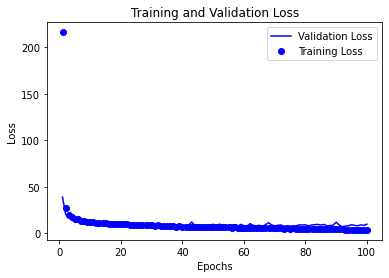

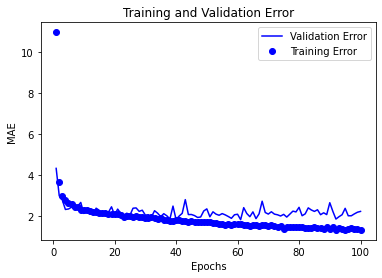

In [46]:
%matplotlib inline

plt.plot(range(1, epoch_count + 1), history.history["val_loss"], "b", label="Validation Loss")
plt.plot(range(1, epoch_count + 1),history.history["loss"], "bo", label="Training Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure()

plt.plot(range(1, epoch_count + 1), history.history["val_mae"], "b", label="Validation Error")
plt.plot(range(1, epoch_count + 1),history.history["mae"], "bo", label="Training Error")
plt.title("Training and Validation Error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

plt.show()

### Now, let's perform the training over K-fold Validation to get averaged validation accuracy

In [17]:
# The function that trains model with K-Fold Validation

def train_model(k_fold_val_count, epoch_count):
    val_samples_count = len(x_train)//k_fold_val_count
    val_mae_history = []
    for i in range(k_fold_val_count):
        print("Processing fold", i+1, "out of", k_fold_val_count, "...")
        x_val_folded = x_train[i * val_samples_count:(i+1) * val_samples_count]
        y_val_folded = y_train[i * val_samples_count:(i+1) * val_samples_count]

        x_train_folded = np.concatenate(
            [x_train[:i*val_samples_count], x_train[(i+1)*val_samples_count:]], axis=0)
        y_train_folded = np.concatenate(
            [y_train[:i*val_samples_count], y_train[(i+1)*val_samples_count:]], axis=0)

        model = create_model()
        history = model.fit(x_train_folded, y_train_folded, 
                            validation_data=(x_val_folded, y_val_folded), 
                            batch_size=1, epochs=epoch_count, verbose=0)
        print("    Average validation MAE ", np.average(history.history["val_mae"]))
        #validation_mse, validation_mae = model.evaluate(x_validation, y_validation, verbose=0)
        val_mae_history.append(history.history["val_mae"])
        
    return val_mae_history

In [11]:
# But before performing K-fold validation based training, lets joins back already splitted 
# training and validation data because the process itself decides on splitting on the data

x_train = np.concatenate([x_train, x_val], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0)

### INFORMATION:
#### Below method <em>"train_model</em>" uses K-fold validation approach and takes longer to train the model on CPU. You may consider this notebook to run over GPU configuration.

In [18]:
# Now, let's train the model over 100 epochs

k_fold_val_count = 4
epoch_count = 100

val_mae_history = train_model(k_fold_val_count, epoch_count)

averaged_mae_across_all_k_fold_validation = np.mean(val_mae_history, axis=0)

Processing fold  1 out of 4
    Average validation MAE  2.449280090332031
Processing fold  2 out of 4
    Average validation MAE  2.8060847473144532
Processing fold  3 out of 4
    Average validation MAE  2.679091444015503
Processing fold  4 out of 4
    Average validation MAE  2.0672685825824737


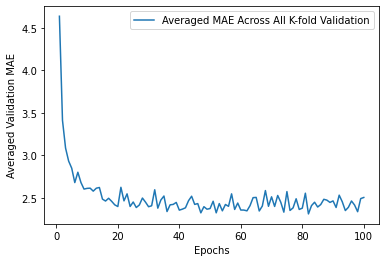

In [19]:
# Plots the training and validation performance

plt.plot(range(1, epoch_count+1), 
         averaged_mae_across_all_k_fold_validation, 
         label="Averaged MAE Across All K-fold Validation")
plt.xlabel("Epochs")
plt.ylabel("Averaged Validation MAE")
plt.legend()
plt.show()

In [21]:
# Let's get that epoch where average MAE is lowest from history

epoch_count_min = np.argmin(averaged_mae_across_all_k_fold_validation)
# OR epoch = np.where(averaged_mae_across_all_k_fold_validation == averaged_mae_across_all_k_fold_validation.min())

print(epoch_count_min)

81


In [24]:
# From the plot it is observed that validation performance does not improve after 20th epochs.
# Let's now build the final model with 50 epochs

epoch_count_min = 50
model = create_model()
model.fit(x_train, y_train, epochs=epoch_count_min, batch_size=1, verbose=0)

In [25]:
# And, then test the above model against test data

test_mse, test_mae = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 15.7942 - mae: 2.3423


In [26]:
print("Test MSE:", test_mse, ", Test MAE:", test_mae)

Test MSE: 15.794160842895508 , Test MAE: 2.3423290252685547
